<a href="https://colab.research.google.com/github/Warvito/GCN/blob/master/Single_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Colab to use GPU

In [49]:
import torch
print(torch.version.cuda)

10.1


Please, create an data.zip file with the following data structure:


*   data
    *   raw
        *   10013.txt
        *   10013.txt
        *   ...     
        *   51256.txt
        *   Labels.csv        

Then upload it to colab using the following cell or usin the files tab.

In [51]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.zip to data.zip
User uploaded file "data.zip" with length 30440738 bytes


In [0]:
! unzip data.zip

In [0]:
!pip3 install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip3 install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip3 install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip3 install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip3 install torch-geometric

In [70]:
# Set random seed
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [0]:
import math
from pathlib import Path

import numpy as np
import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import dense_to_sparse


class ConnectivityData(InMemoryDataset):
    """ Dataset for the connectivity data."""

    def __init__(self,
                 root,
                 sparsity=.2):
        self.sparsity = sparsity
        super(ConnectivityData, self).__init__(root, None, None)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        file_paths = sorted(list(Path(self.raw_dir).glob("*.txt")))
        return [str(file_path.name) for file_path in file_paths]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def binarize(self, matrix):
        """ Calculate the adjacency matrix from the connectivity matrix."""
        triu_numel = int((matrix.size - np.diag(matrix).size) / 2)
        threshold = math.floor(self.sparsity * triu_numel)
        sorted_idx = np.argsort(np.triu(np.abs(matrix), 1), axis=None)
        valid_idx = sorted_idx[-threshold:]
        adj_mat = np.zeros(matrix.shape, dtype='int32').flatten()
        adj_mat[valid_idx] = 1
        adj_mat = adj_mat.reshape(matrix.shape)
        return adj_mat + adj_mat.transpose()

    def process(self):
        labels = np.genfromtxt(Path(self.raw_dir) / "Labels.csv")

        data_list = []
        for filename, y in zip(self.raw_paths, labels):
            y = torch.tensor([y]).long()
            connectivity = np.genfromtxt(filename)
            x = torch.from_numpy(connectivity).float()

            adj = self.binarize(connectivity)
            adj = torch.from_numpy(adj).float()
            edge_index = dense_to_sparse(adj)[0]

            data_list.append(Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [0]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, global_mean_pool


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=0.):
        super(GCN, self).__init__()

        num_features = int(num_features)

        self.conv1 = ChebConv(num_features, 32, K=k_order)
        self.conv2 = ChebConv(32, 32, K=k_order)
        self.conv3 = ChebConv(32, 64, K=k_order)
        self.conv4 = ChebConv(64, 64, K=k_order)
        self.conv5 = ChebConv(64, 128, K=k_order)

        self.lin1 = torch.nn.Linear(128, int(num_classes))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv5(x, edge_index))

        x = global_mean_pool(x, batch)
        x = self.lin1(x)

        return F.log_softmax(x, dim=1)


In [0]:
import torch
from torch_geometric.data import DataLoader

dataset = ConnectivityData('./data')
dataset = dataset.shuffle()
n = len(dataset) // 10
test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=60)
train_loader = DataLoader(train_dataset, batch_size=60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, dataset.num_classes, 9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)




In [74]:
train_curve = []
test_curve = []
for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
          format(epoch, loss, train_acc, test_acc))
    
    train_curve.append(train_acc)
    test_curve.append(test_acc)

Epoch: 001, Loss: 1.04519, Train Acc: 0.61367, Test Acc: 0.55405
Epoch: 002, Loss: 0.67517, Train Acc: 0.65379, Test Acc: 0.58108
Epoch: 003, Loss: 0.66240, Train Acc: 0.69391, Test Acc: 0.62162
Epoch: 004, Loss: 0.65638, Train Acc: 0.69391, Test Acc: 0.67568
Epoch: 005, Loss: 0.65234, Train Acc: 0.72363, Test Acc: 0.63514
Epoch: 006, Loss: 0.63472, Train Acc: 0.73403, Test Acc: 0.60811
Epoch: 007, Loss: 0.60050, Train Acc: 0.73403, Test Acc: 0.62162
Epoch: 008, Loss: 0.56668, Train Acc: 0.75780, Test Acc: 0.62162
Epoch: 009, Loss: 0.54918, Train Acc: 0.76672, Test Acc: 0.68919
Epoch: 010, Loss: 0.51432, Train Acc: 0.77712, Test Acc: 0.70270
Epoch: 011, Loss: 0.50958, Train Acc: 0.79346, Test Acc: 0.70270
Epoch: 012, Loss: 0.47700, Train Acc: 0.81129, Test Acc: 0.68919
Epoch: 013, Loss: 0.45034, Train Acc: 0.82169, Test Acc: 0.68919
Epoch: 014, Loss: 0.42825, Train Acc: 0.81724, Test Acc: 0.67568
Epoch: 015, Loss: 0.40072, Train Acc: 0.85736, Test Acc: 0.68919
Epoch: 016, Loss: 0.35939

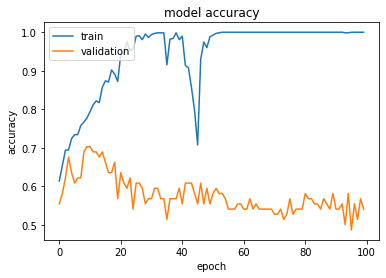

In [75]:
import matplotlib.pyplot as plt

plt.plot(train_curve)
plt.plot(test_curve)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()